In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [95]:
# data_preprocess

BTC_1m_bar = pd.read_csv('btc_1min_bar.csv')
data = BTC_1m_bar
data['datetime'] = pd.to_datetime(data['datetime'])
data['future_30min_return'] = (data['close'].shift(-30) / data['close']) - 1


In [261]:
# def factor generator 

def factor_reversal(input):


    data = input.copy()
    data['returns'] = data['close'].pct_change()

    weights = np.arange(1, 61)  

    data['factor'] = data['returns'].rolling(window=60).apply(
        lambda x: np.average(x, weights=weights[-len(x):]), raw=True)
    
    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)


    return result

def factor_logCloseVolume(input):
    data = input.copy()
    epsilon = 1e-9  

    data['close'] = data['close'].replace(0, epsilon)
    data['volume'] = data['volume'].replace(0, epsilon)

    data['factor'] = np.log((data['close'] + epsilon) / (data['close'].shift(30) + epsilon)) * \
                     np.log((data['volume'] + epsilon) / (data['volume'].shift(30) + epsilon))
    
    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result

def factor_PRET(input):

    data = input.copy()

    data['returns'] = data['close'].pct_change()

    data['PRET'] = data['close'].shift(1) - data['close'].shift(5)/data['close'].shift(1)
    data['pos'] = np.where(data['returns'] > 0, 1, 0)
    data['msum_pos'] = data['pos'].rolling(window=5).sum()

    data['iif_result'] = np.where(data['PRET'] > 0, 1, -1)


    data['factor'] = data['iif_result'] * (5 -  (data['msum_pos']))/5 - (data['msum_pos'])/5

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result


def factor_return_pow(input):

    data = input.copy()

    data['minute_return'] = data['close'].pct_change()


    return_mean = data['minute_return'].rolling(window=15).mean()
    
    term_pow3 = (data['minute_return'] - return_mean) ** 3
    sum_pow3 = term_pow3.rolling(window=15).sum()

    term_pow2 = (data['minute_return'] - return_mean) ** 2
    sum_pow2 = term_pow2.rolling(window=15).sum()
    denominator = sum_pow2 ** 1.5
    
    result = sum_pow3 / denominator

    data['factor'] = result

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result


def factor_upVolitity(input):

    data = input.copy()

    data['minute_return'] = data['close'].pct_change()

    data['upside_returns'] = np.where(data['minute_return'] > 0, data['minute_return'], np.nan)

    data['up_volatility'] = data['upside_returns'].rolling(window=15, min_periods= 1).std()

    data['volatility'] = data['minute_return'].rolling(window=15, min_periods = 1).std()

    data['factor'] = data['up_volatility'] / data['volatility']



    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result


def factor_trendStrength(input):

    data = input.copy()

    close_shift = data['close'].shift(5)

    delta_close = data['close'].diff()

    msum_delta = abs(delta_close).rolling(5).sum()

    factor = (data['close'] - close_shift)/msum_delta

    data['factor'] = factor

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result


def factor_bull_bear_index(input):

    data = input.copy()

    data['minute_return'] = data['close'].pct_change()

    volume_standard = data['volume']/data['volume'].rolling(5).mean()

    volitity = data['minute_return'].rolling(20).std()

    volume_avg = volume_standard.rolling(20).mean()

    factor = volume_avg / volitity

    data['factor'] = factor

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result

def factor_QRS(input):

    data = input.copy()

    std_high = data['high'].rolling(120).std()

    std_low = data['low'].rolling(120).std()

    corr_high_low = data['high'].rolling(120).corr(data['low'])

    factor = std_high/std_low*corr_high_low * corr_high_low**2

    data['factor'] = factor

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result
    
def factor_lowMid(input):

    data = input.copy()

    low_50 = data['low'].rolling(30).quantile(0.5)

    factor = low_50/low_50.rolling(5).mean()

    data['factor'] = factor

    result = data[['datetime','symbol','factor','future_30min_return']]
    result.set_index('datetime', inplace=True)

    return result


In [90]:
reversal = factor_reversal(data)
logCloseVolume = factor_logCloseVolume(data)
PRET = factor_PRET(data)
return_pow = factor_return_pow(data)
up_volitity = factor_upVolitity(data)
trend_strength = factor_trendStrength(data)
bull_bear_index = factor_bull_bear_index(data)
QRS = factor_QRS(data)
lowMid = factor_lowMid(data)

In [211]:
# def time series factor evaluation plot and result function

def calculate_and_plot(data,direaction,name):


    # 计算每30分钟回报的z分数
    data['zscore_factor'] = preprocessing.scale(data['factor'])

    # 计算所需的每日指标
    data['daily_metric'] = data['zscore_factor'] * data['future_30min_return']
    daily_sum = data['daily_metric'].resample('D').sum()
    daily_sum  = daily_sum * direaction
    # 累加值
    cumulative_sum = daily_sum.cumsum()

    plt.figure(figsize=(24, 4))
    cumulative_sum.plot(title='Cumulative Sum of (zscore(factor) * 30min_returns)'+' of factor '+name)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum')
    plt.grid(True)
    plt.show()

    return cumulative_sum


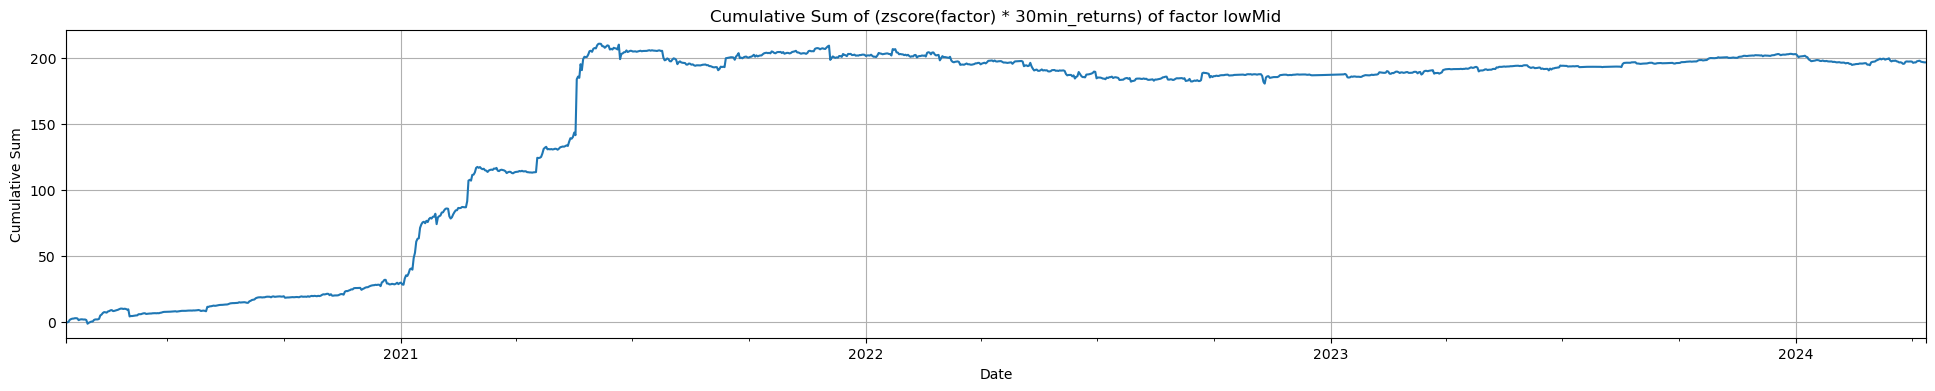

datetime
2020-04-13     -0.481860
2020-04-14     -0.417525
2020-04-15     -0.083002
2020-04-16      1.480942
2020-04-17      2.047983
                 ...    
2024-04-08    197.117490
2024-04-09    196.819127
2024-04-10    196.655076
2024-04-11    196.520793
2024-04-12    196.520793
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

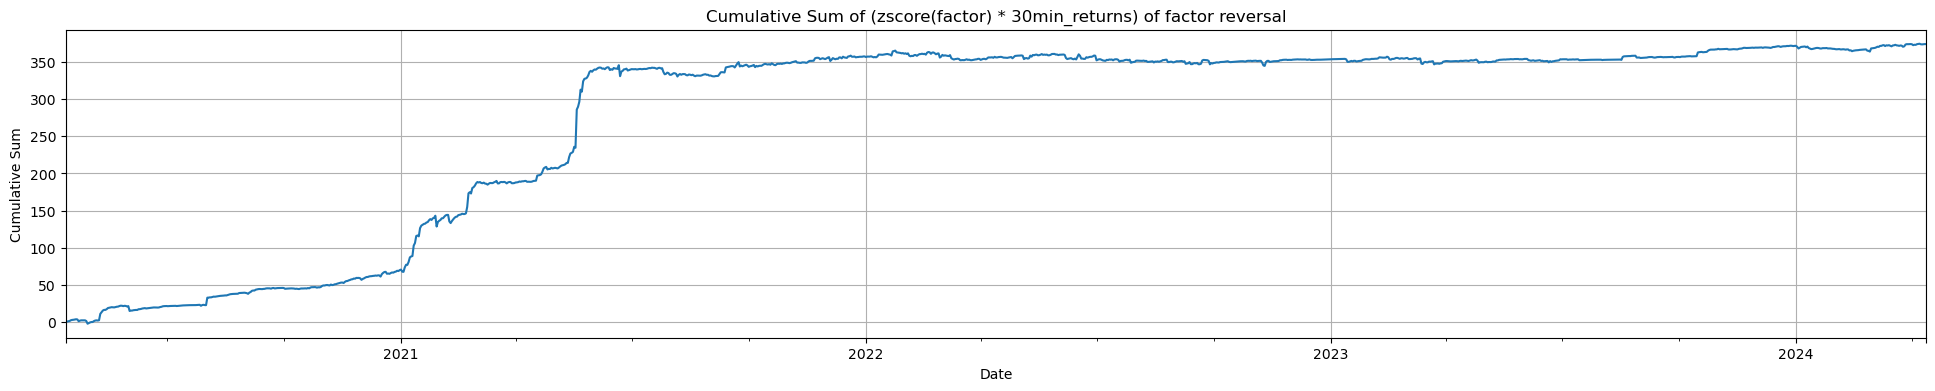

datetime
2020-04-13      0.059404
2020-04-14      0.483587
2020-04-15      0.961004
2020-04-16      1.320341
2020-04-17      2.310986
                 ...    
2024-04-08    374.073275
2024-04-09    373.905308
2024-04-10    374.135213
2024-04-11    374.304184
2024-04-12    374.304184
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [173]:
calculate_and_plot(reversal,-1,'reversal')

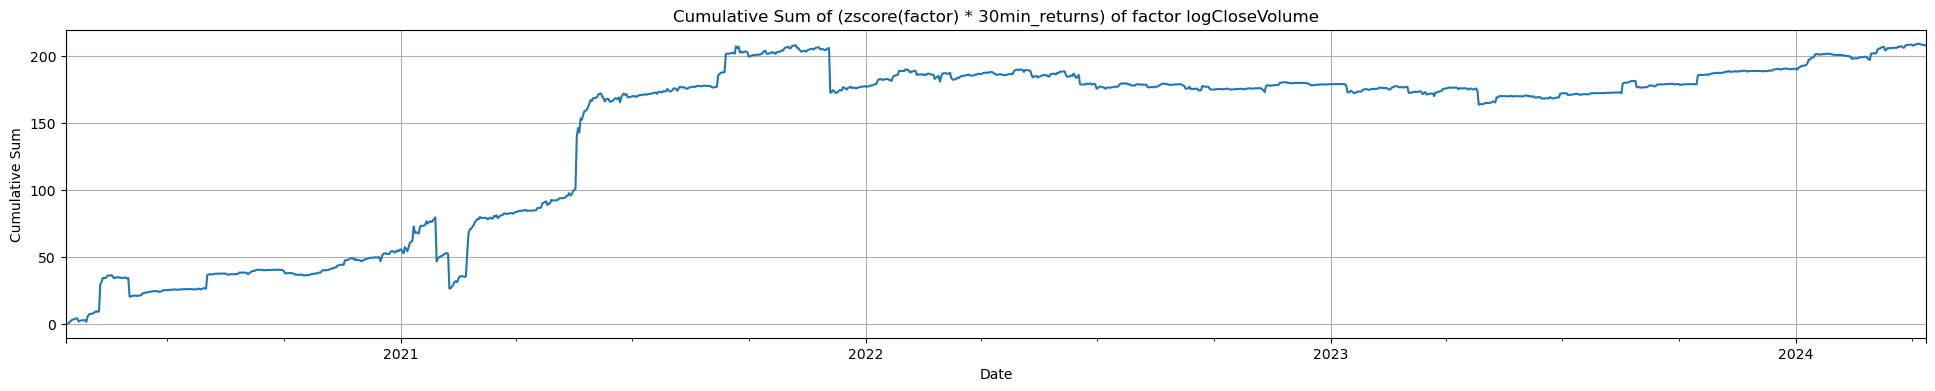

datetime
2020-04-13     -0.100961
2020-04-14      0.022891
2020-04-15      0.098087
2020-04-16      1.372568
2020-04-17      2.056518
                 ...    
2024-04-08    208.194949
2024-04-09    208.080939
2024-04-10    208.026606
2024-04-11    207.600968
2024-04-12    207.600968
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [174]:
calculate_and_plot(logCloseVolume,-1,'logCloseVolume')

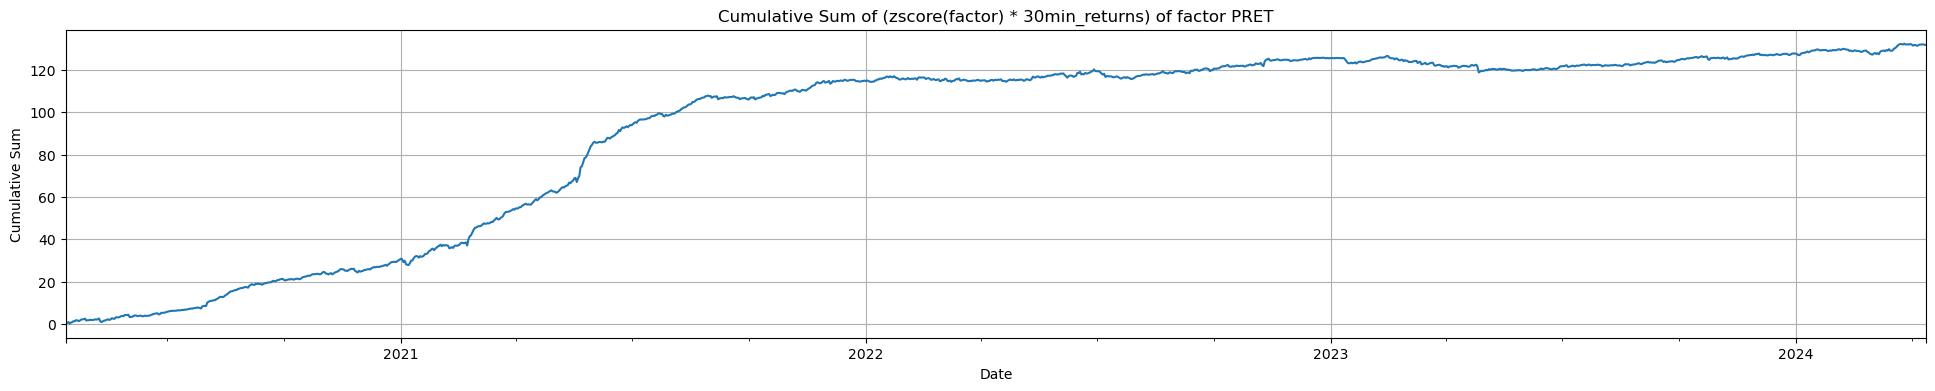

datetime
2020-04-13      0.162692
2020-04-14      0.445342
2020-04-15      0.849800
2020-04-16      0.049371
2020-04-17      0.616631
                 ...    
2024-04-08    131.994539
2024-04-09    132.029913
2024-04-10    132.087213
2024-04-11    131.865972
2024-04-12    131.865972
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [175]:
calculate_and_plot(PRET,1,'PRET')

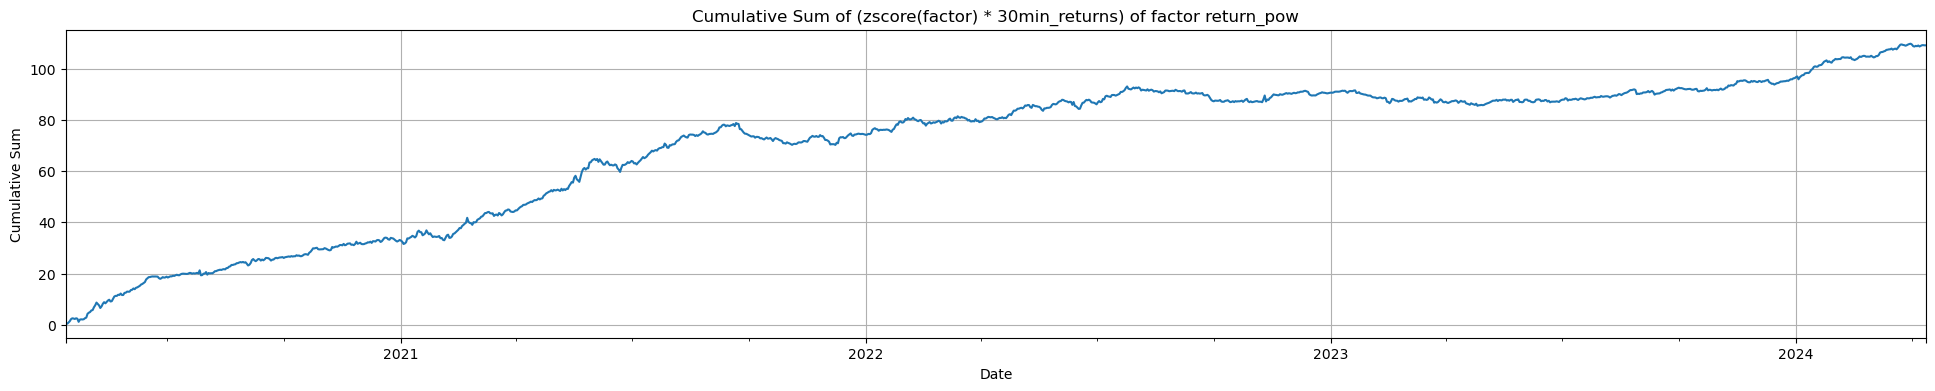

datetime
2020-04-13      0.468400
2020-04-14      0.393321
2020-04-15      0.842377
2020-04-16      1.359813
2020-04-17      2.167483
                 ...    
2024-04-08    108.990094
2024-04-09    109.261937
2024-04-10    109.265634
2024-04-11    109.202855
2024-04-12    109.202855
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [176]:
calculate_and_plot(return_pow,-1,'return_pow')

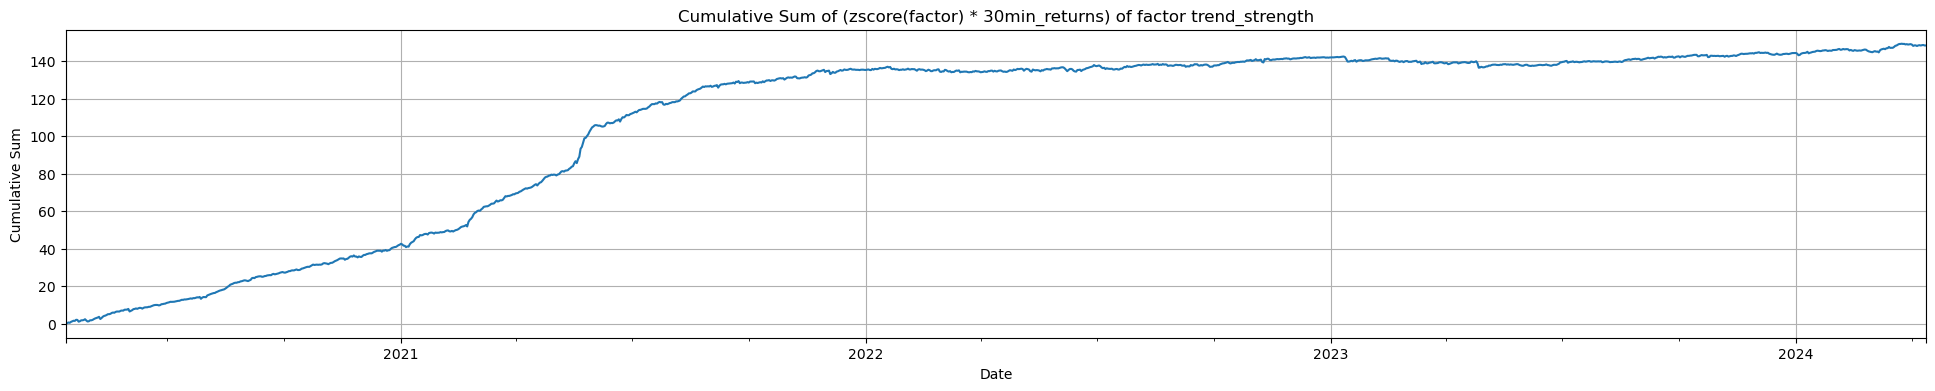

datetime
2020-04-13     -0.037077
2020-04-14      0.325511
2020-04-15      0.622217
2020-04-16      0.455490
2020-04-17      0.958567
                 ...    
2024-04-08    148.245036
2024-04-09    148.453515
2024-04-10    148.516984
2024-04-11    148.265075
2024-04-12    148.265075
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [177]:
calculate_and_plot(trend_strength,-1,'trend_strength')

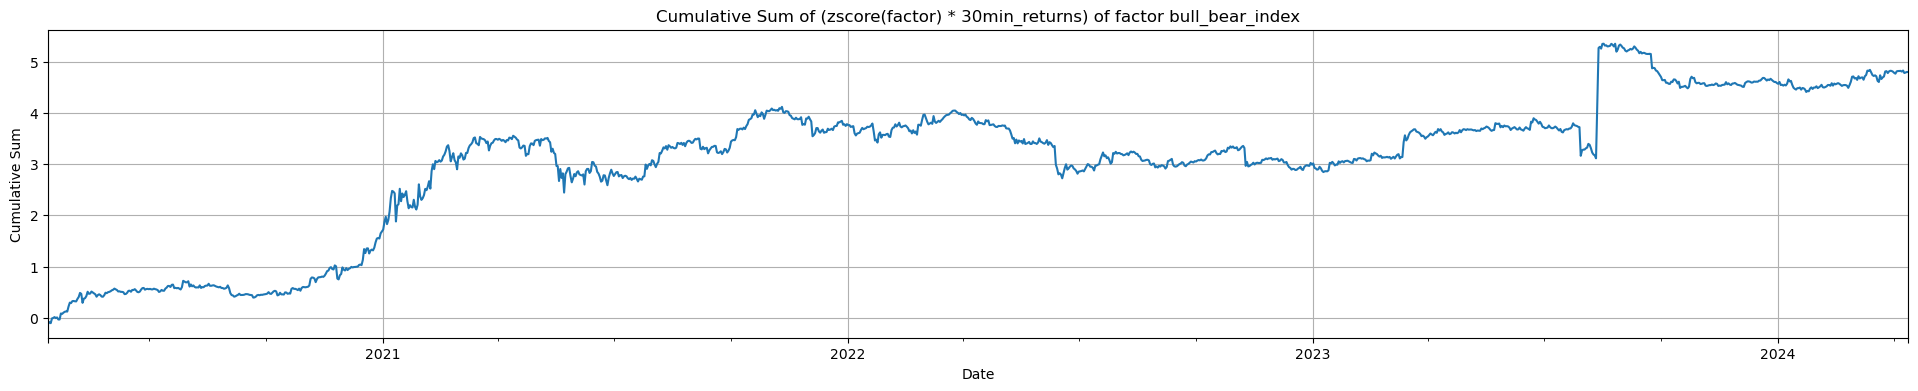

datetime
2020-04-13   -0.113541
2020-04-14   -0.081244
2020-04-15   -0.102752
2020-04-16   -0.010238
2020-04-17   -0.001156
                ...   
2024-04-08    4.826060
2024-04-09    4.777548
2024-04-10    4.787104
2024-04-11    4.797323
2024-04-12    4.797323
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [251]:
calculate_and_plot(bull_bear_index,-1,'bull_bear_index')

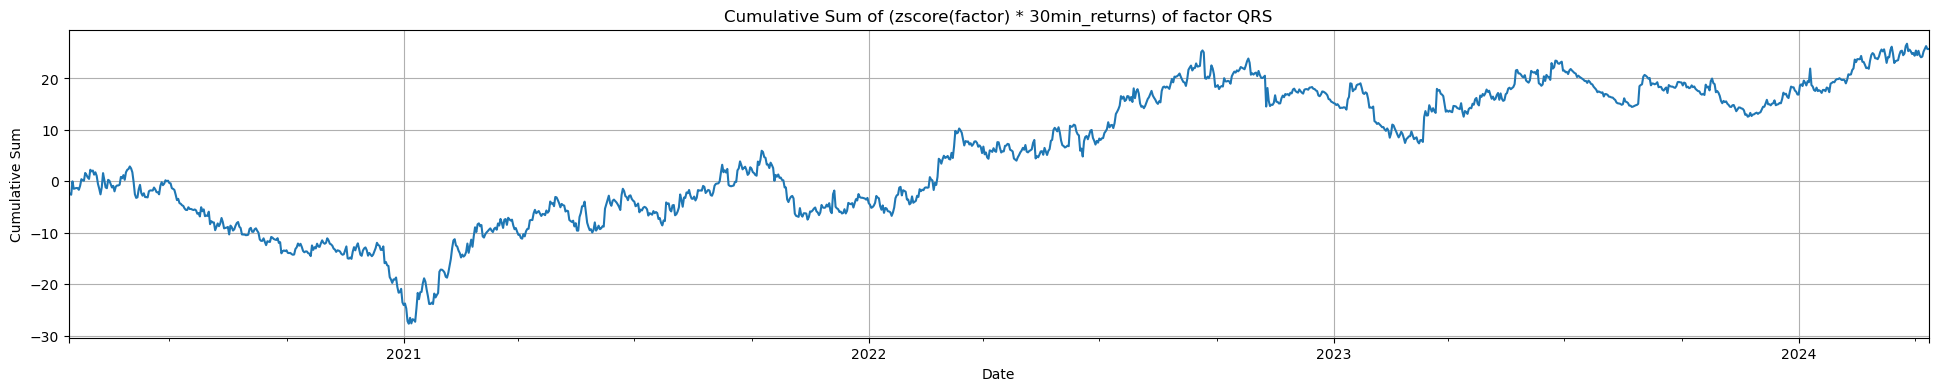

datetime
2020-04-13    -2.111468
2020-04-14    -2.442649
2020-04-15    -2.599750
2020-04-16    -0.000852
2020-04-17    -1.447502
                ...    
2024-04-08    25.233711
2024-04-09    25.784758
2024-04-10    26.295064
2024-04-11    25.727181
2024-04-12    25.727181
Freq: D, Name: daily_metric, Length: 1461, dtype: float64

In [252]:
calculate_and_plot(QRS,1,'QRS')

In [ ]:
calculate_and_plot(lowMid,-1,'lowMid')

In [264]:
all_factors = pd.DataFrame({'reversal': reversal['factor'],
                           'logCloseVolume': logCloseVolume['factor'],
                           'PRET' : PRET['factor'],
                           'return_pow':return_pow['factor'],
                           'up_volitity':up_volitity['factor'],
                           'trend_strength': trend_strength['factor'],
                           'bull_bear_index':bull_bear_index['factor'],
                           'QRS':QRS['factor'],
                           'lowMid':lowMid['factor']
                           
                           })

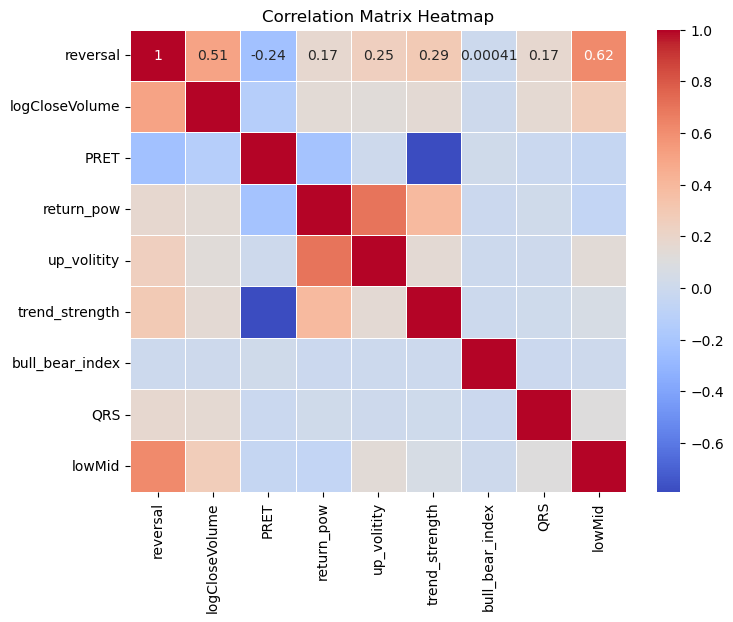

In [265]:
correlation_matrix = all_factors.corr()
plt.figure(figsize=(8, 6))  # 设置图形的大小
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [266]:
correlation_matrix

,reversal,logCloseVolume,PRET,return_pow,up_volitity,trend_strength,bull_bear_index,QRS,lowMid
reversal,1.000000,0.505970,-0.236458,0.172210,0.251655,0.291629,0.000407,0.173175,0.619332
logCloseVolume,0.505970,1.000000,-0.127147,0.144384,0.129822,0.150730,0.001658,0.157577,0.271626
PRET,-0.236458,-0.127147,1.000000,-0.218665,0.001125,-0.789421,0.014438,-0.015401,-0.047567
return_pow,0.172210,0.144384,-0.218665,1.000000,0.700269,0.389972,-0.007777,0.020620,-0.060157
up_volitity,0.251655,0.129822,0.001125,0.700269,1.000000,0.151979,-0.005641,0.000649,0.134321
trend_strength,0.291629,0.150730,-0.789421,0.389972,0.151979,1.000000,-0.001610,0.012801,0.062119
bull_bear_index,0.000407,0.001658,0.014438,-0.007777,-0.005641,-0.001610,1.000000,-0.011361,0.000519
QRS,0.173175,0.157577,-0.015401,0.020620,0.000649,0.012801,-0.011361,1.000000,0.107477
lowMid,0.619332,0.271626,-0.047567,-0.060157,0.134321,0.062119,0.000519,0.107477,1.000000
